In [19]:
from preprocessing.data_cleaning import get_cleaned_data, split_csv
from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_patientwise_errors, plot_labels_pie_chart, plot_blood_draw_statistics

In [20]:
df = get_cleaned_data()

/Users/kyle/Documents/COMP 449/TARCC/Code/TARCC_F22/preprocessing/data_cleaning.py:426: DtypeWarning: Columns (30,157,383,384,393,480,724,725,762) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/TARCC_data.csv")


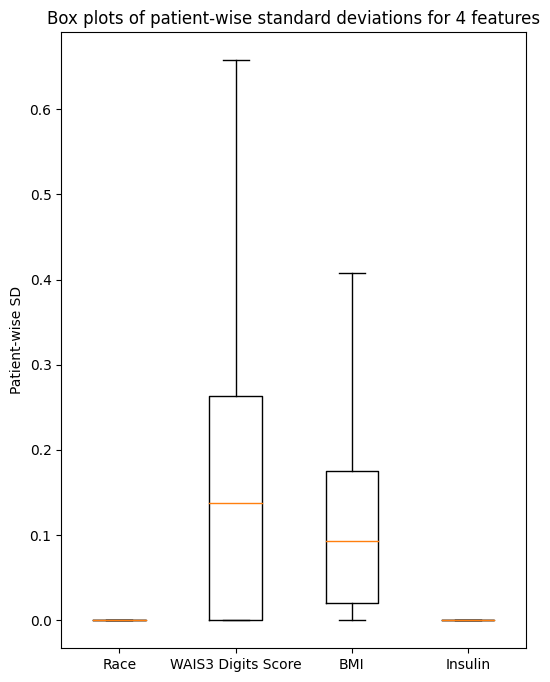

In [21]:
plot_patientwise_errors(
    df,
    ["A1_RACE", "C1_WAIS3_DIGTOT", "B1_BMI", "RBM_Insulin"],
    ["Race", "WAIS3 Digits Score", "BMI", "Insulin"],
    png="Patientwise Errors"
)

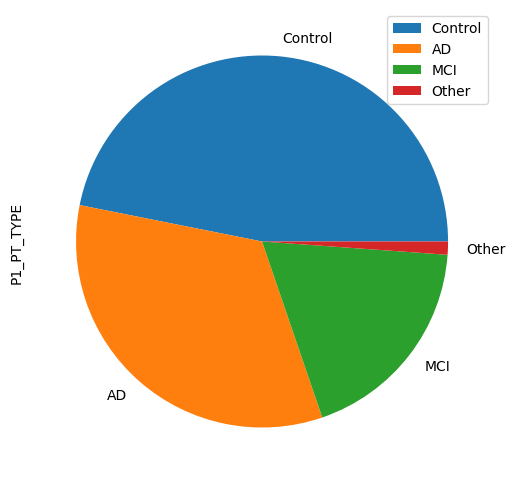

In [22]:
plot_labels_pie_chart(df, png="Pie Chart of Diagnoses")

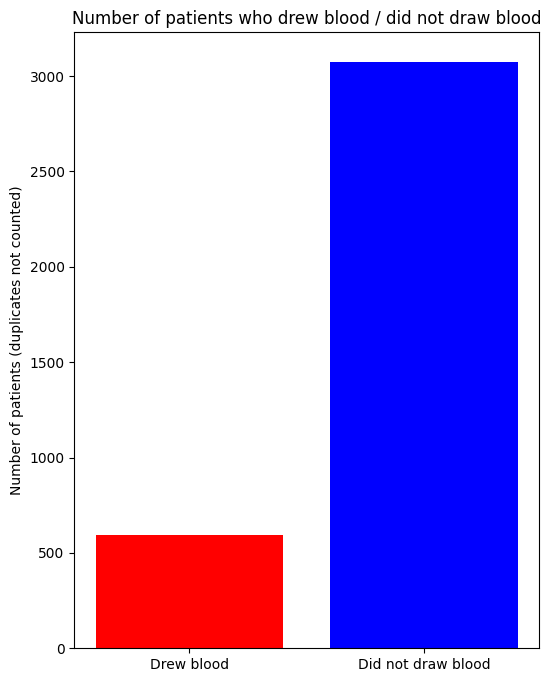

In [23]:
plot_blood_draw_statistics(df, png="Blood Draw Proportions")

/Users/kyle/Documents/COMP 449/TARCC/Code/TARCC_F22/exploration/data_correlations.py:97: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_values = df.corr()


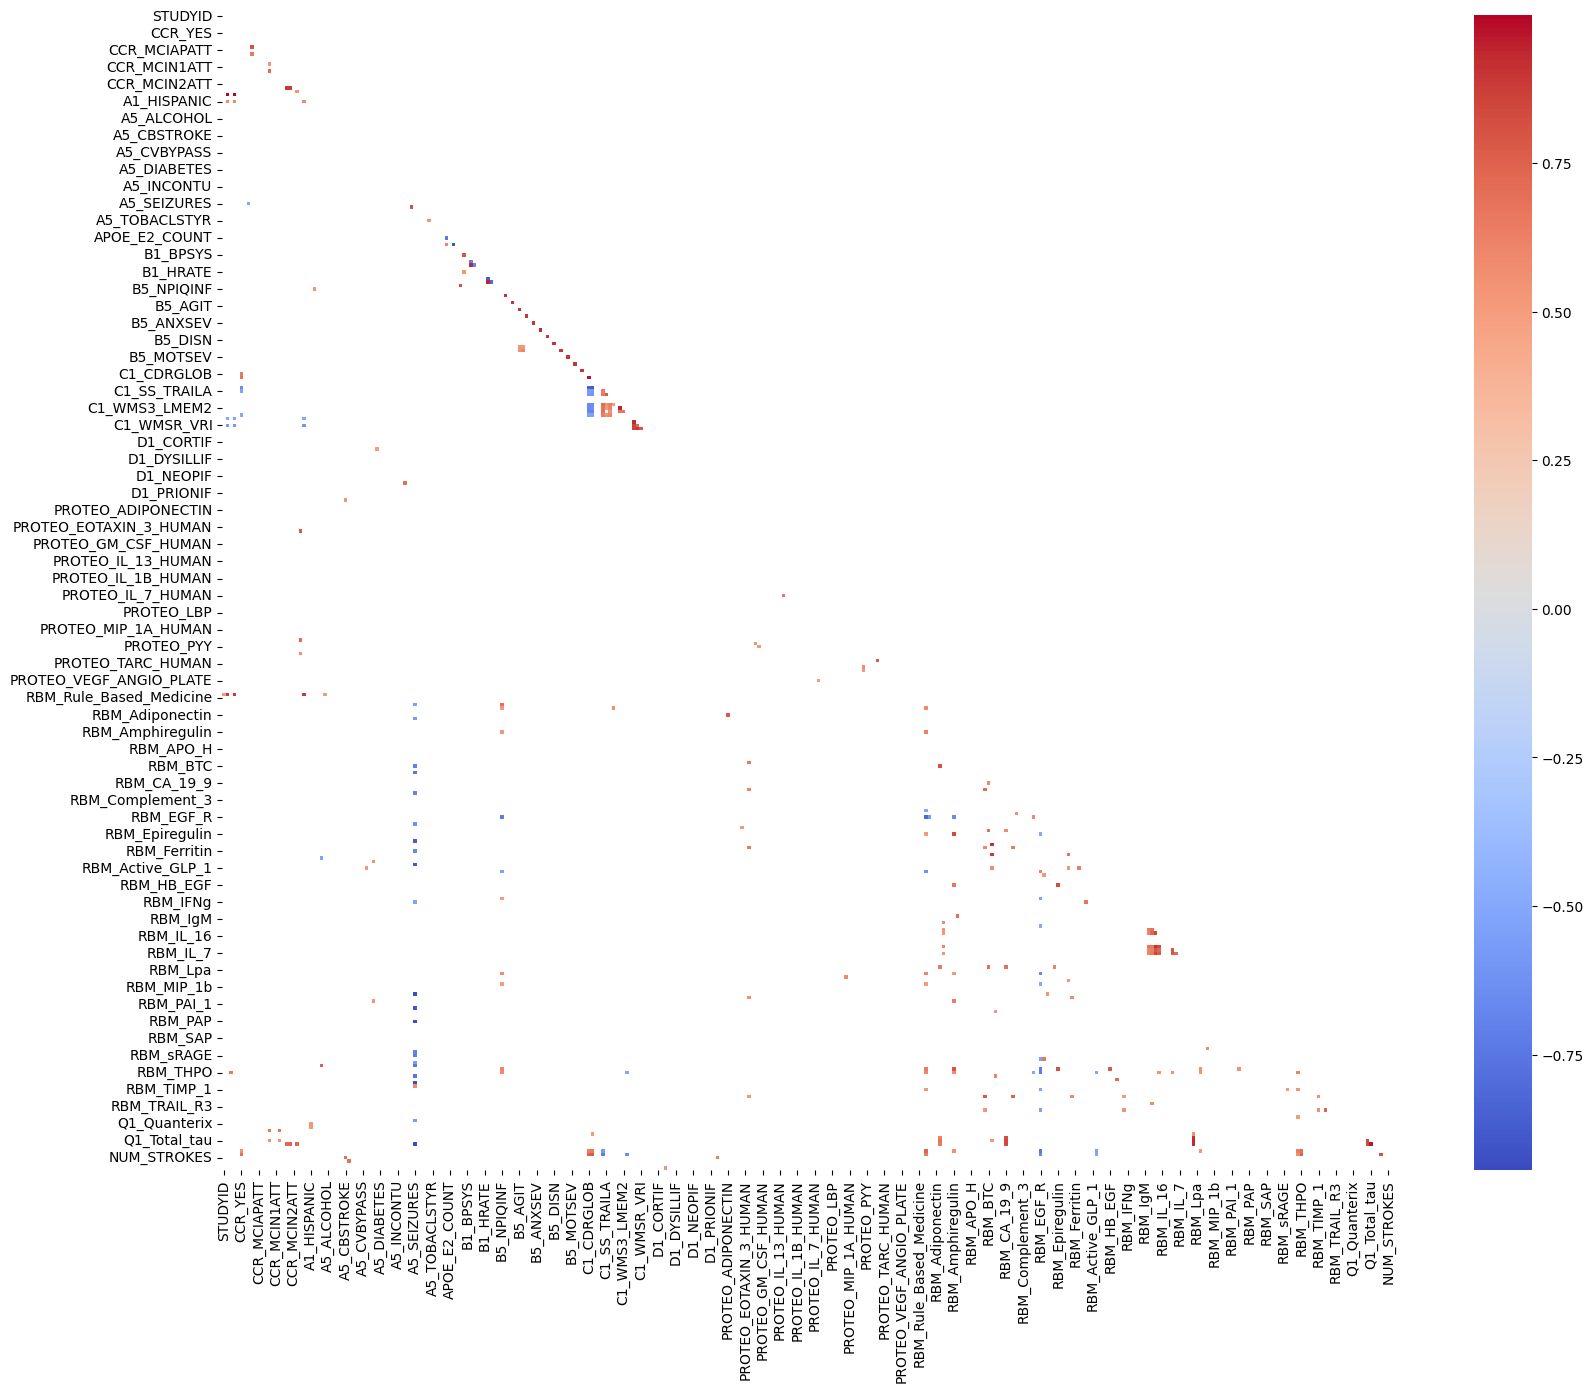

In [24]:
plot_correlations(df)

In [25]:
blood_df, clinical_df = split_csv(df)